## DATA CLEANING

#### This notebook cleans and prepares data for the Capstone1 Project Orthopedic Feature Classification of Spondylolisthesis of Lumbar Back.

#### Exploratory statistical analysis is performed to determine outliers, colinearity, and correlation amoungst features.

#### The results are 4 dataframes, 1 (df) complete/encoded target, 1 (data) complete/string target, 1 (X) Feature-only, 1 (Y) Target-only 

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder   # Encode target
from scipy.stats import gamma, poisson, norm, t, ttest_ind
#from numpy.random import seed
from scipy import stats

### Load - Explore - Rename columns


In [23]:
data = pd.read_csv('Data/weka2c.csv')         # import 1 file
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          310 non-null    float64
 1   pelvic_tilt numeric       310 non-null    float64
 2   lumbar_lordosis_angle     310 non-null    float64
 3   sacral_slope              310 non-null    float64
 4   pelvic_radius             310 non-null    float64
 5   degree_spondylolisthesis  310 non-null    float64
 6   class                     310 non-null    object 
dtypes: float64(6), object(1)
memory usage: 17.1+ KB


In [24]:
#    RENAME COLUMNS
data = data.rename(columns = {'pelvic_incidence':'incidence', 'pelvic_tilt numeric': 'tilt',
                           'lumbar_lordosis_angle': 'angle', 'sacral_slope': 'slope',
                           'pelvic_radius': 'radius', 'degree_spondylolisthesis' : 'degree',
                            'class':'class'}).dropna()
data_str = data.copy(deep=True)

In [25]:
data.describe()

,incidence,tilt,angle,slope,radius,degree
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


### Remove Outliers

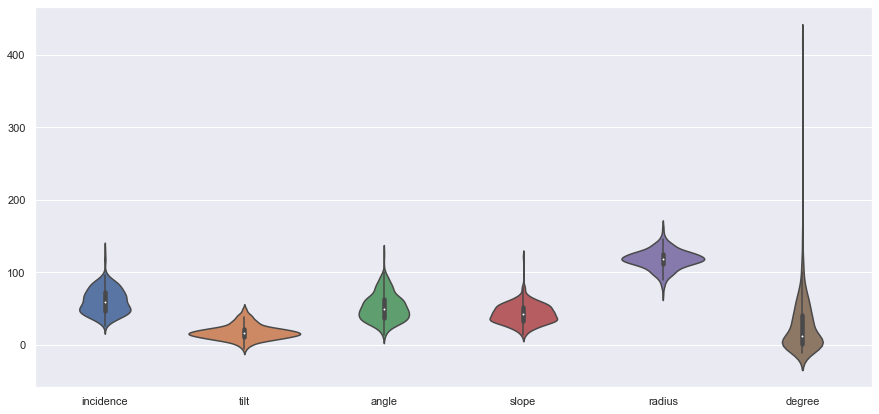

In [26]:
# Identify potential outliers with an IQR above 1.5, statistically significant for Tukey method
sns.set(rc={'figure.figsize':(15,7)})
ax = sns.violinplot(data=data, whis=1.5)

#### Note:  "Degree" has the most obvious potential outliers - using Tukey's method for validation

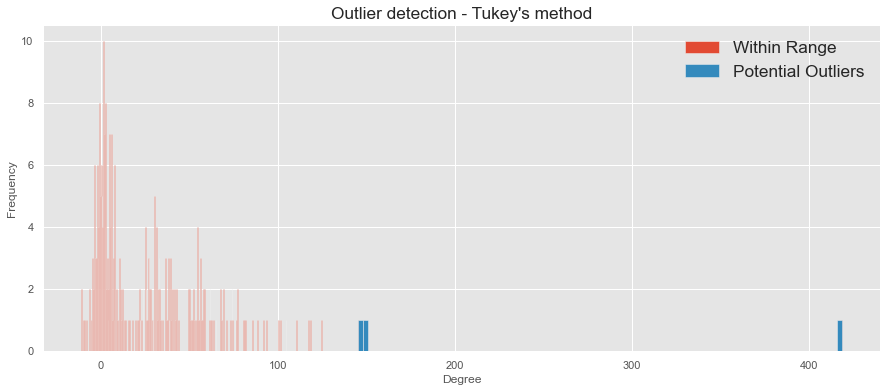

In [27]:
# Function detects potential outliers with Turkey's method comparing the z-score against a preset threshold

def tukey_outliers(data) -> list:
    plt.style.use('ggplot')
    threshold = 3
    mean = np.mean(data)
    std = np.std(data)
    outliers = []
    for i in data:
        z_score = (i - mean) / std
        if abs(z_score) > threshold:
            outliers.append(i)
    return outliers
spond_outliers = tukey_outliers(data['degree'])

plt.figure(figsize=(15,6))
data['degree'].plot(kind='hist', bins=1000, label='Within Range')
plt.hist(spond_outliers, bins = 100, label='Potential Outliers')
plt.title("Outlier detection - Tukey's method", fontsize='xx-large')
plt.xlabel('Degree')
plt.legend(fontsize='xx-large')

In [28]:
data = data.loc[data['degree'] <= 140]     # Remove the oulier, values > 360

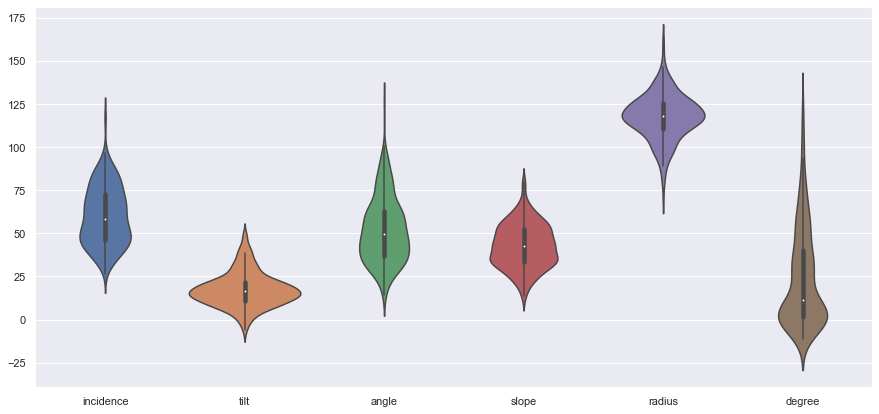

In [29]:
sns.set(rc={'figure.figsize':(15,7)})
ax = sns.violinplot(data=data, whis=1.5)   # Review after removal

### With outlier removal all feature data lies within IQR

### Encode target as boolean - Create Feature and Target Variables

In [30]:
label_encoder = LabelEncoder()                            # construct encoder
data.iloc[:,6] = label_encoder.fit_transform(data.iloc[:,6])  # encode
data.iloc[:,6] = np.ravel(data.iloc[:,6])                     # reshape

In [31]:
X = data.drop(['class'],axis=1).copy(deep=True)             # create predictor variable (features)
Y = data[['class']]                                         # Create Target variable

### Review correlations - remove correlations >90% between features

<AxesSubplot:>

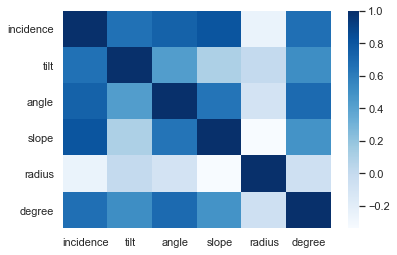

In [32]:
sns.set(rc={'figure.figsize':(6,4)})
sns.heatmap(X.corr(), cmap="Blues")

In [33]:
# Remove features that have >90% correlation with each other
corr = X.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = X.columns[columns]
data = X[selected_columns]

### Review Feature-Target correlation

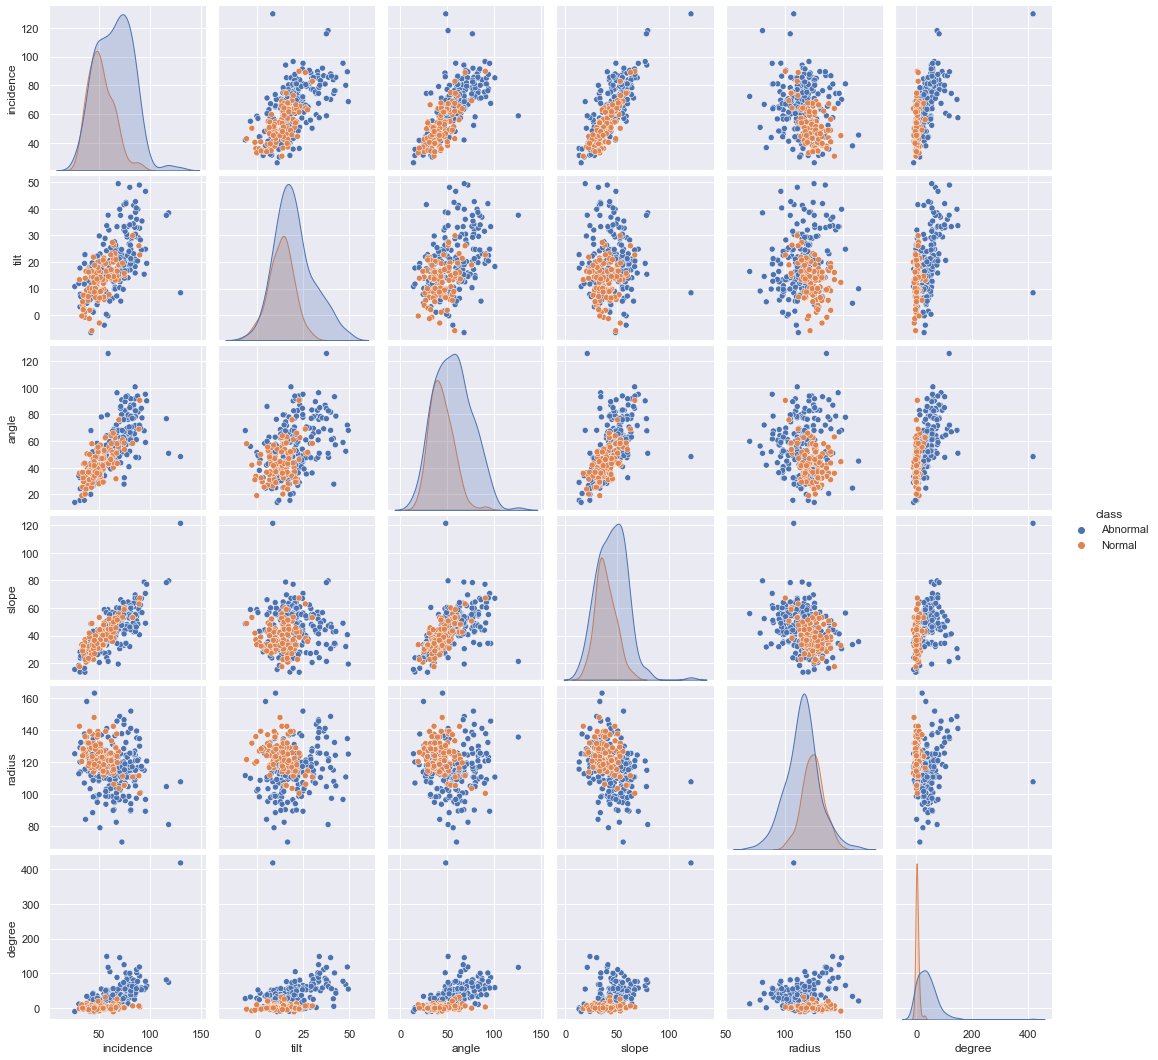

In [34]:
sns.pairplot(data_str, hue="class")       # "Class" only correlations
plt.show()

Text(0.5, 1.02, 'Distribution of Features')

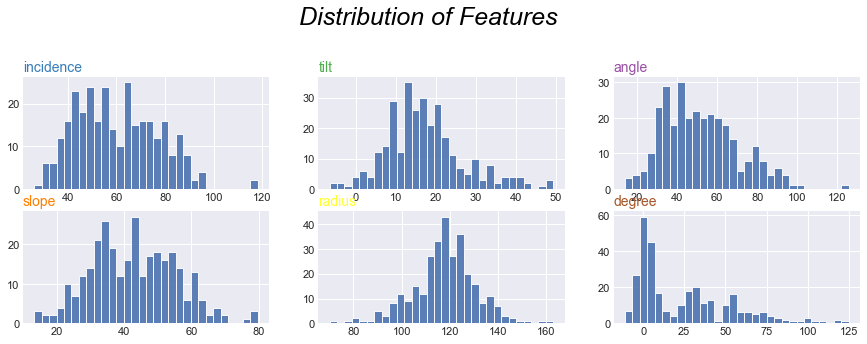

In [35]:
#                                  PLOT DATA DISTRIBUTION OF ALL FEATURES
sns.set(rc={'figure.figsize':(15,7)})
plt.style.use('seaborn-darkgrid')
palette = plt.get_cmap('Set1')
num = 0
for column in X:
    num+=1
    plt.subplot(3,3, num)
    plt.hist(X[column], bins=30, alpha=0.9, label=column)
#    plt.xlim(0,10)
#    plt.ylim(-2,22)
    
    if num in range(7) :
        plt.tick_params(labelbottom='off')
    if num not in [1,4,7] :
        plt.tick_params(labelleft='off')
    
    plt.title(column, loc='left', fontsize=14, fontweight=0, color=palette(num))

plt.suptitle("Distribution of Features", fontsize=25, fontweight=0, color='black', style='italic', y=1.02)

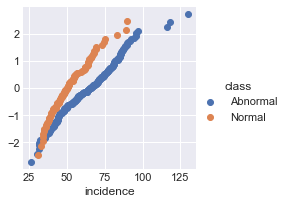

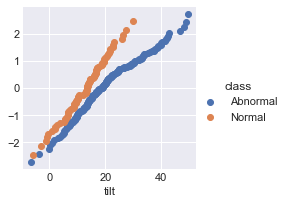

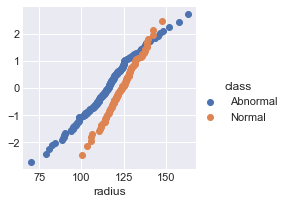

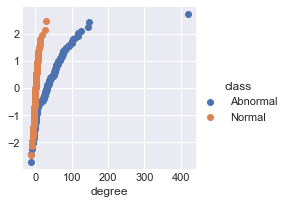

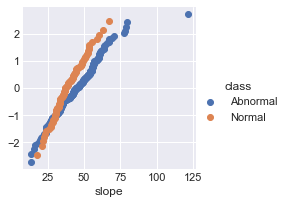

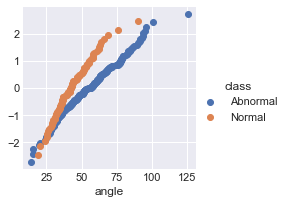

In [36]:
columns = ['incidence', 'tilt','radius','degree','slope', 'angle']
for column in columns:
    x = data_str[[column, 'class']]

    def quantile_plot(x, **kwargs):
        quantiles, xr = stats.probplot(x, fit=False)
        plt.scatter(xr, quantiles, **kwargs)

#    g = sns.FacetGrid(x, col="class", height=3)
    g = sns.FacetGrid(x, hue='class', height=3)
    g.map(quantile_plot, column)
    g.add_legend()

### Above is seen clear statistical significance to nullify the hypthesis test for degree and radius.  Note:  The degree and radius features are complementary, if feature selection necessary these two would be most useful.

### Below, test the hypothesis:   No statistically significant difference exists between 'Abnormal' and 'Normal' class features
### A TTest was performed due to 2 classes of quantitative continuous variables, the probability of alpha = 0.5% was set as the standard.

In [53]:
#   TTEST FUNCTION
columns = ['incidence','angle','slope','degree','tilt','radius']
column_names = ["Feature", "compare", "p-value","ttest"]
results = pd.DataFrame(columns = column_names, inplace=True)

def test(y, var,results):
    for column in columns:
        a, b = stats.ttest_ind(y,X[column], equal_var = var)
#        print("The p-value for ",column,":  ",np.mean(b))
#        print("The ttest for ",column,": ",abs(np.mean(a)))
        results = results.append({"Feature" : y, "compare":column,"p-value":np.mean(b),
                                  "ttest":np.mean(a)},ignore_index=True)
        return results

SyntaxError: invalid syntax (<ipython-input-53-db8027a24e7b>, line 4)

In [51]:
print("P-values for the Radius target vs all Features: ",test(X[['radius']],False,results))

P-values for the Radius target vs all Features:                                               Feature    compare  \
0           radius
0     98.672917
1    114.40542...  incidence   

         p-value      ttest  
0  3.567848e-200  47.110132  


In [ ]:
print("P-values for the Tilt target vs all Features: ",test(X[['tilt']],False))

In [ ]:
print("P-values for the Slope target vs all Features: ",test(X[['slope']],False))

In [ ]:
print("P-values for the Degree target vs all Features: ",test(X[['degree']],False))

In [ ]:
print("P-values for the Incidence target vs all Features: ",test(X[['incidence']],False))

In [ ]:
print("P-values for the Angle target vs all Features: ",test(X[['angle']],False))

### ABOVE: All features pass ttest and p-value

### BELOW: results are reviewed and passed to csv files

In [ ]:
print(df['class'].value_counts())           # End count of features
print(data.nunique()) 

# save feature frames for Machine Learning notebook
data.to_csv('Data/data.csv',index=False)  # Full dataset non-Encoded
df.to_csv('Data/df.csv',index=False)      # Full dataset Encoded
X.to_csv('Data/X.csv',index=False)      # Feature set
Y.to_csv('Data/Y.csv',index=False)      # Target set